#MNIST 데이터를 이용해 손글씨 숫자 이미지를 분류하는 간단한 CNN 구현

# 1. 모듈 불러오기

기본적으로 프로젝트 상단에 작성

In [8]:
#Pytorch 라이브러리
import torch

#딥러닝 네트워크의 기본 구성요소를 포함한 torch.nn모듈
import torch.nn as nn

#딥러닝에 자주 사용되는 함수를 포함한 torch.nn.functional 모듈
import torch.nn.functional as F

#가중치 추정에 필요한 최적화 알고리즘을 포함한 torch.optim 모듈
import torch.optim as optim

#딥러닝에 자주 사용되는 데이터셋과 모델 구조 및 이미지 변환 기술을 포함한 torchvision
from torchvision import datasets, transforms

#시각화
from matplotlib import pyplot as plt
#주피터 노트북에서, 브라우저에서 바로 그림을 보려면 실행해야함
%matplotlib inline 

# 2. 분석환경 세팅

데이터에 어떤 장비를 사용할지 지정해야하므로, device를 미리 작성하는 것이 유용

In [9]:
#cuda로 gpu를 사용할 수 있으면, is_cuda=True, 사용할 수 없다면 is_cuda=False
is_cuda = torch.cuda.is_available()

#is_cuda에 따라 device = cuda or cpu
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)
#cpu 사용시, Current cuda device is cpu
#gpu 사용시, Current cuda device is cuda

Current cuda device is cuda


# 3. hyperparameter 지정

필요한 hyperparameter를 미리 지정

In [10]:
#모델 가중치를 한번 업데이트 시킬때 사용되는 샘플 단위 개수(미니배치 사이즈)
batch_size = 50

#학습 데이터를 모두 사용하여 1번 학습하는 기본 단위 횟수 = 1epoch
epoch_num = 15

#가중치 업데이트의 정도
learning_rate = 0.0001

# 4. MNIST 데이터 불러오기

pytorch 모듈안에 내장되어 있어서 쉽게 불러올 수 있음

In [11]:
#root = MNIST 데이터를 저장할 위치

#train = True이면 학습데이터, False이면 테스트데이터

#download = True이면, 다운받아서 root에 지정한 폴더에 저장, False이면 다운받지 않는다

#transform = MNIST 데이터를 저장과 동시에 지정한 함수로 전처리
#transforms.ToTensor()는 이미지를 tensor로 바꿔준다.

train_data = datasets.MNIST(root = './data', train=True, download=True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train=False, transform = transforms.ToTensor())

#len()함수로 데이터 개수 확인
print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


# 5. 데이터 확인

데이터의 일부를 시각화를 통해 확인

torch.Size([1, 28, 28])
torch.Size([28, 28])


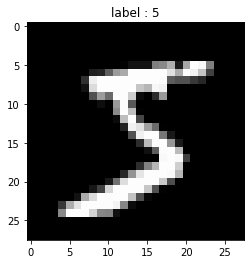

In [12]:
#0번째 학습데이터와 정답을 저장
image, label = train_data[0]

print(image.shape)
#MNIST는 3차원 텐서로 [1,28,28]

#3차원 텐서를 2차원으로 줄이기 위해 image.squeeze()로 [28,28]로 바꿔줌

print(image.squeeze().shape)

#image tensor를 numpy array로 바꿔줘야 확인 가능
plt.imshow(image.squeeze().numpy(), cmap = 'gray')

plt.title('label : %s' %label)

plt.show()

# 6. 미니 배치 구성

미리 지정한 batch_size로 미니 배치를 구성

In [13]:
#torch.utils.data.DataLoader()은 손쉽게 배치를 구성하고, 학습 과정을 반복 시행할때마다 미니 배치를 하나씩 불러온다

#dataset = 미니 배치로 구성할 데이터
#batch_size = 미니 배치의 사이즈 = 50
#shuffle = 데이터의 순서를 랜덤으로 섞어서 미니 배치를 구성할지 여부
#시계열 데이터가 아니라면, 딥러닝이 데이터의 순서에 대해 학습하지 못하도록 랜덤으로 섞어주는 것을 권장
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

first_batch = train_loader.__iter__().__next__()

print('{:15s} | {:<25s} | {}'.format('name','type','size'))
print('{:15s} | {:<25s} | {}'.format('Num of Batch','',len(train_loader)))
print('{:15s} | {:<25s} | {}'.format('first_batch',str(type(first_batch)),len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]',str(type(first_batch[0])),first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]',str(type(first_batch[1])), first_batch[1].shape))

#1200개의 미니 배치 생성
#60000개의 train데이터에서, 배치 사이즈로 50을 설정했으니, 50*1200 = 60000
#first_batch[0]의 size가 [50,1,28,28]은 [batch_size, channel, width, height]
#데이터 1개가 [1,28,28]인데, 50개 쌓여서 [50,1,28,28]
#first_batch[1]에는 50개의 각 데이터마다 정답이 있어서 size가 [50]

name            | type                      | size
Num of Batch    |                           | 1200
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


# 7. 모델 구축

In [14]:
#nn.Module은 pytorch 모델 클래스가 상속받는 모듈 클래스
#__init__ 메소드와 forward 메소드를 반드시 설정해야함
class CNN(nn.Module):
    
    #모델에 사용되는 layer들을 정의
    def __init__(self):
        
        #nn.Module 클래스의 상속을 상속받는다.
        super(CNN,self).__init__()

        #in_channels, out_channels, kernel_size, stride

        #in_channels는 input tensor의 channel
        #out_channels는 output tensor의 channel
        #kernel_size는 kernel의 크기, 값 하나로 주면 가로 세로가 같은 kernel, tuple로 주면 세로*가로 형태

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1)

        #conv1을 통과한 tensor의 channel이 32이고 이것이 conv2를 통과하므로..
        #conv2의 in_channels는 32여야함
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1)

        #dropout layer 정의

        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        #fullyt connected layer 정의

        self.fc1 = nn.Linear(in_features = 9216, out_features = 128)

        #마지막 layer의 out_features는 MNIST의 분류 클래스가 0~9로 10개이므로.. 10으로
        #당연히 in_features는 이전 fc1의 out_features와 같게
        self.fc2 = nn.Linear(in_features = 128, out_features = 10)
    
    #feed forward 연산을 수행하는 forward 메소드 정의

    #layer를 통과시키고
    #중간중간에 활성함수를 넣고
    #중간중간에 dropout 등을 넣어준다

    def forward(self, x):
        
        x = self.conv1(x)

        #activation
        x = F.relu(x)
        
        x = self.conv2(x)

        x = F.relu(x)

        #max_pooling
        x = F.max_pool2d(x,2)

        #dropout
        x = self.dropout1(x)

        #flatten
        x = torch.flatten(x,1)

        x = self.fc1(x)

        x = F.relu(x)

        x = self.dropout2(x)

        x = self.fc2(x)

        #확률 벡터로 바꾸기 위해 softmax를 적용
        #log softmax를 사용하면 연산속도를 높여줄 수 있음
        output = F.log_softmax(x,dim=1)

        return output




# 8. optimizer, loss function 정의

In [16]:
#CNN 클래스로 모델 인스턴스 생성
#to(device)를 수행하면, 모델 인스턴스를 device에 올릴 수 있다

model = CNN().to(device)

#optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#loss function
#다중 클래스 분류 문제이므로, cross entropy 사용
criterion = nn.CrossEntropyLoss()

In [17]:
#모델 확인

print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 9. 모델 학습

optimizer.zero_grad() > output = model(data) > loss = criterion(output,target) > loss.backward() > optimizer.step()

In [18]:
#모델을 학습 모드로 바꿔준다
model.train()

i = 0

#epoch_num만큼 반복학습 수행
for epoch in range(epoch_num):
    
    #각 epoch내에서 train_loader를 순회
    for data,target in train_loader:
        
        #모델에 할당된 device에 data,target들도 할당해줘야함

        data = data.to(device)
        target = target.to(device)

        #optimizer에 저장된 gradient 초기화
        optimizer.zero_grad()

        #모델에 data 통과시켜 output 계산
        output = model(data)

        #loss 계산
        loss = criterion(output,target)

        #gradient계산

        loss.backward()

        #가중치 업데이트
        optimizer.step()

        #학습이 잘 되고 있는지 1000번째 배치마다, loss가 어떻게 변하는지 확인
        if i % 1000 == 0:
            
            print('Train Step: {}\tLoss: {:.3f}'.format(i,loss.item()))
        
        i += 1

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Step: 0	Loss: 2.311
Train Step: 1000	Loss: 0.194
Train Step: 2000	Loss: 0.253
Train Step: 3000	Loss: 0.077
Train Step: 4000	Loss: 0.246
Train Step: 5000	Loss: 0.014
Train Step: 6000	Loss: 0.126
Train Step: 7000	Loss: 0.062
Train Step: 8000	Loss: 0.021
Train Step: 9000	Loss: 0.144
Train Step: 10000	Loss: 0.015
Train Step: 11000	Loss: 0.039
Train Step: 12000	Loss: 0.009
Train Step: 13000	Loss: 0.040
Train Step: 14000	Loss: 0.151
Train Step: 15000	Loss: 0.027
Train Step: 16000	Loss: 0.019
Train Step: 17000	Loss: 0.052


# 10. 모델 평가

In [19]:
#모델을 평가모드로 전환
#dropout, batchnormalization을 test 모드로 바꿔줌
model.eval()

correct = 0 #정답 개수

#gradient를 계산하지 않도록 해준다.
#계산속도 증가, 메모리 절약
with torch.no_grad():
    
    #test_loader를 순회해서 배치와 label을 가져오고
    for data, target in test_loader:
        
        #모델과 동일한 device에 할당
        data = data.to(device)
        target = target.to(device)

        #output 계산
        output = model(data)

        #가장 확률이 높은 부분의 인덱스를 찾아 그것을 예측값 클래스로 전환

        prediction = output.data.max(1)[1]

        #prediction과 target값을 비교하여, correct에 더해준다
        correct += prediction.eq(target.data).sum()

#전체 테스트 데이터 개수 대비 맞춘 개수 비율 계산

print('Test set: Accuracy: {:.2f}%'.format(100*correct/len(test_loader.dataset)))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test set: Accuracy: 99.05%
